<a href="https://colab.research.google.com/github/stavco9/neuralnetworks-final-project/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Training Template (PyTorch)

This notebook provides a template for training a neural network using PyTorch.

---

## 1. Dataset Loading and Preparation

In [1]:
import os
import re
import random
import math
import imutils
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
import keras_ocr

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
from PIL import Image, ImageOps
from IPython.display import display
#import pytesseract
#import cv2
import io

#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
#os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
curr_dir = os.getcwd()


C:\Users\stavc\projects\idc_msc\neural-networks\neuralnetworks-final-project\neural-nets-env\Lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.25.2 and <2.6.0 is required for this version of SciPy (detected version 1.25.0)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# for DataLoader shuffling
g = torch.Generator()
g.manual_seed(SEED)

In [3]:
hugging_face_ds = load_dataset("George511242/Facebook_harmeme_dataset")

In [4]:
# Load train and test sets to pandas
hugging_face_train_df = hugging_face_ds["train"].to_pandas()
hugging_face_test_df = hugging_face_ds["test"].to_pandas()

In [5]:
# Convert ID's to numeric
hugging_face_train_df["id"] = pd.to_numeric(hugging_face_train_df["id"])
hugging_face_test_df["id"] = pd.to_numeric(hugging_face_test_df["id"])

In [6]:
# Build standard columns for textual prompt and a boolean label weather the content is harmful
def build_textual_prompt_object(df):
    if 'conversations' in df.columns:
        all_conversations = list(df['conversations'])
        df['textual_prompt'] = [item[0]['value'] for item in all_conversations]
        df['is_harmful'] = [item[1]['value'] for item in all_conversations]
        df['is_harmful'] = df['is_harmful'].eq('Yes').mul(True)

build_textual_prompt_object(hugging_face_train_df)
build_textual_prompt_object(hugging_face_test_df)

In [7]:
def get_image_text(df):
    list_image_texts = []
    if 'image_text' in df.columns:
        return df['image_text']

    for prompt in df['textual_prompt']:
        match = re.search(r'The text in the meme is: (.*?)\.\n<image>\n', prompt)
        if match:
            list_image_texts.append(match.group(1))
        else:
            list_image_texts.append('')
    return list_image_texts

hugging_face_train_df['image_text'] = get_image_text(hugging_face_train_df)
hugging_face_test_df['image_text'] = get_image_text(hugging_face_test_df)

In [8]:
# Save all images bytes in files and save in the dataframe the image path
os.makedirs('images', exist_ok=True)

def build_images_column(df):
    if 'image_path' in df.columns:
        return df['image_path']

    list_paths = []
    for image in df['image']:
        save_path = f"images/{image['path']}"
        list_paths.append(save_path)

        if not os.path.exists(save_path):
            with open(save_path, 'wb') as f:
                f.write(image['bytes'])
    return list_paths

hugging_face_train_df['image_path'] = build_images_column(hugging_face_train_df)
hugging_face_test_df['image_path'] = build_images_column(hugging_face_test_df)

In [37]:
# Remove not used columns after being proccesed
hugging_face_train_df = hugging_face_train_df.drop(columns=['image', 'conversations', 'image_tensor', 'image_path_no_text'], errors='ignore')
hugging_face_test_df = hugging_face_test_df.drop(columns=['image', 'conversations', 'image_tensor', 'image_path_no_text'], errors='ignore')

In [38]:
hugging_face_train_df.loc[hugging_face_train_df.id == 1243].image_text.values[0]

'when your human says "who\' s a good girl?" and you already know it\'s you'

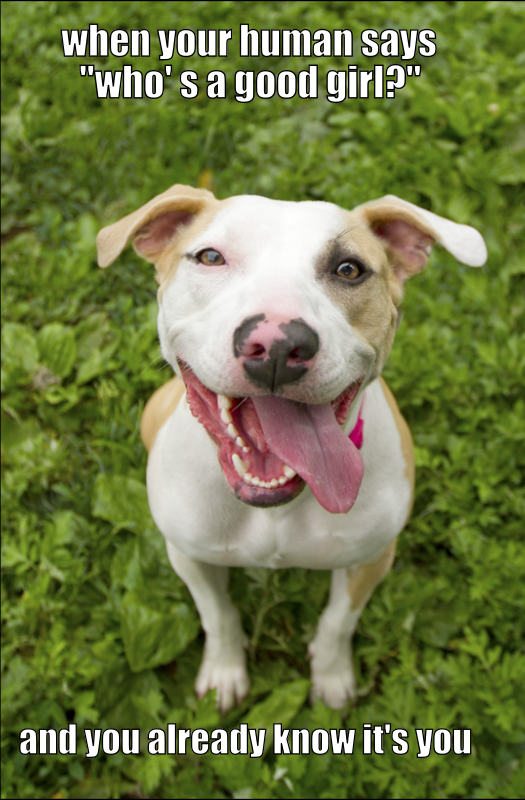

In [39]:
image_path = hugging_face_train_df.loc[hugging_face_train_df.id == 1243].image_path.values[0]
img = Image.open(image_path)
display(img)

In [40]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)
pipeline = keras_ocr.pipeline.Pipeline()

def inpaint_text_new(img_path, pipeline):
    # Load image
    img = keras_ocr.tools.read(img_path)
    
    # Run OCR
    prediction_groups = pipeline.recognize([img])
    
    # Initialize mask
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    # Go over each detected text box
    for _, box in prediction_groups[0]:
        # Create polygon from the 4 corners
        pts = np.array(box, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 255)

    # Inpaint once after all masks are drawn
    inpainted = cv2.inpaint(img, mask, inpaintRadius=7, flags=cv2.INPAINT_NS)
    
    return inpainted

def inpaint_text_new_new(img_path, pipeline):
    # Load image
    img = keras_ocr.tools.read(img_path)
    
    # Run OCR
    prediction_groups = pipeline.recognize([img])
    
    # Initialize mask
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    
    # Go over each detected text box
    for _, box in prediction_groups[0]:
        # Create polygon from the 4 corners
        pts = np.array(box, dtype=np.int32)
        cv2.fillPoly(mask, [pts], 255)

    #kernel = np.ones((3, 3), np.uint8)
    #mask = cv2.dilate(mask, kernel, iterations=1)
    
    # Inpaint once after all masks are drawn
    inpainted = cv2.inpaint(img, mask, inpaintRadius=7, flags=cv2.INPAINT_TELEA)
    
    return inpainted
    
def inpaint_text(img_path, pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
    return(img)

Looking for C:\Users\stavc\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\stavc\.keras-ocr\crnn_kurapan.h5


In [41]:
def build_image_path_no_text(df):
    if 'image_path_no_text' in df.columns:
        return df['image_path_no_text']

    list_paths = []
    os.makedirs("images-no-text", exist_ok=True)
    
    chunk_size = 60
    for image_path in df['image_path'].values:
        save_path = image_path.replace("images", "images-no-text")

        image_id = int(re.findall(r'\d+', image_path)[0])
        if not os.path.exists(save_path):
            image_no_text = Image.fromarray(inpaint_text_new_new(image_path, pipeline))
            image_no_text.save(save_path)
        
        list_paths.append(save_path)
    return list_paths

In [42]:
hugging_face_train_df['image_path_no_text'] = build_image_path_no_text(hugging_face_train_df)

In [43]:
hugging_face_test_df['image_path_no_text'] = build_image_path_no_text(hugging_face_test_df)

In [44]:
hugging_face_train_df

,id,textual_prompt,is_harmful,image_text,image_path,image_path_no_text
0,1235,A direct or indirect attack on people based on...,True,when you're feeling horny asf but your habibi ...,images/01235.png,images-no-text/01235.png
1,1236,A direct or indirect attack on people based on...,False,meanwhile at the isis strip club,images/01236.png,images-no-text/01236.png
2,1243,A direct or indirect attack on people based on...,False,"when your human says ""who' s a good girl?"" and...",images/01243.png,images-no-text/01243.png
3,1245,A direct or indirect attack on people based on...,True,and that was the last nativity play my son was...,images/01245.png,images-no-text/01245.png
4,1247,A direct or indirect attack on people based on...,True,you can't be racist if there is no other race,images/01247.png,images-no-text/01247.png
...,...,...,...,...,...,...
8495,98752,A direct or indirect attack on people based on...,False,shut up ontario,images/98752.png,images-no-text/98752.png
8496,98754,A direct or indirect attack on people based on...,True,400 years of slavery rape and murder but now s...,images/98754.png,images-no-text/98754.png
8497,98756,A direct or indirect attack on people based on...,True,this dude wants to use the same restroom as yo...,images/98756.png,images-no-text/98756.png
8498,98762,A direct or indirect attack on people based on...,False,child in poverty with empty water jug,images/98762.png,images-no-text/98762.png


In [12]:
# Define the image transformations to apply to each image
image_size = 128
image_crop_size = 128

transform_train = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomResizedCrop(image_crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

#print(f"image transform: {transform}")

In [13]:
def build_image_tensors(df, transform):
    if 'image_tensor' in df.columns:
        return df['image_tensor']

    image_tensors = []
    for i, path in enumerate(df['image_path']):
        img = Image.open(path).convert("RGB") # Ensure consistent channel format
        tensor_img = transform(img)
        image_tensors.append(tensor_img)

        if ((i+1) % 100 == 0):
            print(f"Complete {i+1} of {len(df['image_path'])} images")
    return image_tensors

hugging_face_train_df['image_tensor'] = build_image_tensors(hugging_face_train_df, transform_train)
hugging_face_test_df['image_tensor'] = build_image_tensors(hugging_face_test_df, transform_test)

Complete 100 of 8500 images
Complete 200 of 8500 images
Complete 300 of 8500 images
Complete 400 of 8500 images
Complete 500 of 8500 images
Complete 600 of 8500 images
Complete 700 of 8500 images
Complete 800 of 8500 images
Complete 900 of 8500 images
Complete 1000 of 8500 images
Complete 1100 of 8500 images
Complete 1200 of 8500 images
Complete 1300 of 8500 images
Complete 1400 of 8500 images
Complete 1500 of 8500 images
Complete 1600 of 8500 images
Complete 1700 of 8500 images
Complete 1800 of 8500 images
Complete 1900 of 8500 images
Complete 2000 of 8500 images
Complete 2100 of 8500 images
Complete 2200 of 8500 images
Complete 2300 of 8500 images
Complete 2400 of 8500 images
Complete 2500 of 8500 images
Complete 2600 of 8500 images
Complete 2700 of 8500 images
Complete 2800 of 8500 images
Complete 2900 of 8500 images
Complete 3000 of 8500 images
Complete 3100 of 8500 images
Complete 3200 of 8500 images
Complete 3300 of 8500 images
Complete 3400 of 8500 images
Complete 3500 of 8500 i

In [ ]:
hugging_face_train_df.head()

,id,textual_prompt,is_harmful,image_text,image_path,image_tensor
0,1235,A direct or indirect attack on people based on...,True,when you're feeling horny asf but your habibi ...,images/01235.png,"[[[tensor(0.6863), tensor(0.7569), tensor(0.76..."
1,1236,A direct or indirect attack on people based on...,False,meanwhile at the isis strip club,images/01236.png,"[[[tensor(0.9608), tensor(0.9804), tensor(0.98..."
2,1243,A direct or indirect attack on people based on...,False,"when your human says ""who' s a good girl?"" and...",images/01243.png,"[[[tensor(0.3569), tensor(0.3922), tensor(0.43..."
3,1245,A direct or indirect attack on people based on...,True,and that was the last nativity play my son was...,images/01245.png,"[[[tensor(0.0235), tensor(0.0196), tensor(0.08..."
4,1247,A direct or indirect attack on people based on...,True,you can't be racist if there is no other race,images/01247.png,"[[[tensor(0.0863), tensor(0.0980), tensor(0.09..."


In [ ]:
hugging_face_test_df.head()

,id,textual_prompt,is_harmful,image_text,image_path,image_tensor
0,1268,A direct or indirect attack on people based on...,False,father and daughter bonding time is the best l...,images/01268.png,"[[[tensor(0.5922), tensor(0.5922), tensor(0.60..."
1,1456,A direct or indirect attack on people based on...,True,they see them rollin..... they hating..,images/01456.png,"[[[tensor(0.6235), tensor(0.1961), tensor(0.29..."
2,1726,A direct or indirect attack on people based on...,True,a real man loads the dishwasher every night,images/01726.png,"[[[tensor(0.3569), tensor(0.5255), tensor(0.49..."
3,1742,A direct or indirect attack on people based on...,False,in just one hour from now i'll only have 4 hou...,images/01742.png,"[[[tensor(0.6588), tensor(0.6863), tensor(0.78..."
4,1765,A direct or indirect attack on people based on...,True,"after a girl dies, what organ in her body stay...",images/01765.png,"[[[tensor(0.0784), tensor(0.0863), tensor(0.08..."


In [ ]:
def plot_class_distribution(df, color, dataset_type):
    fig = plt.figure(figsize=(5, 5))
    is_harmful = df['is_harmful'].astype(int)

    plt.hist(is_harmful, bins=2, align='left', edgecolor='black', color=color)
    plt.xticks([0, 0.5], ['False', 'True'])
    plt.xlabel("Is Harmful ?")
    plt.ylabel("Count")
    plt.title(f"{dataset_type} dataset")

    plt.show()

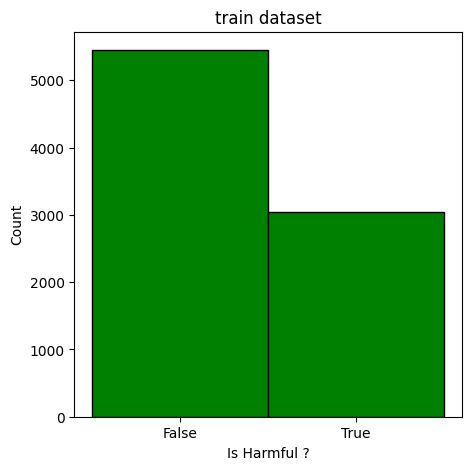

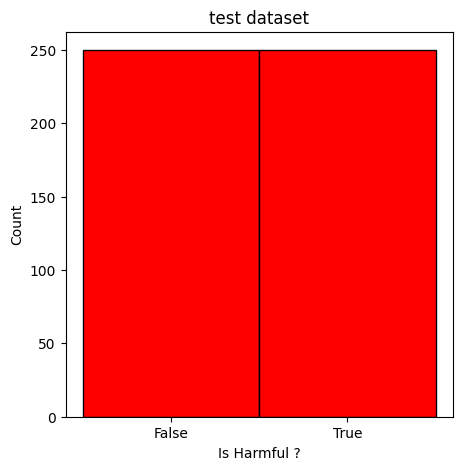

In [ ]:
plot_class_distribution(hugging_face_train_df, 'green', 'train')
plot_class_distribution(hugging_face_test_df, 'red', 'test')

In [14]:
classes = np.unique(hugging_face_train_df['is_harmful'])  # array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=hugging_face_train_df['is_harmful'])

print(class_weights)

[0.77981651 1.39344262]


## 2. Pytorch Model

In [15]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Learnable parameters: scale (gamma) and shift (beta)
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        if self.training:
            mean = x.mean([0, 2, 3], keepdim=True)
            var  = x.var ([0, 2, 3], keepdim=True, unbiased=False)

            with torch.no_grad():
                self.running_mean.mul_(1 - self.momentum).add_(self.momentum * mean.squeeze())
                self.running_var .mul_(1 - self.momentum).add_(self.momentum * var.squeeze())

            x_hat = (x - mean) / torch.sqrt(var + self.eps)
        else:
            mean = self.running_mean.view(1, -1, 1, 1)
            var  = self.running_var .view(1, -1, 1, 1)
            x_hat = (x - mean) / torch.sqrt(var + self.eps)

        return self.gamma.view(1, -1, 1, 1) * x_hat + self.beta.view(1, -1, 1, 1)

In [16]:
class HarmfulDetectionResnet(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.7, freeze_backbone=False):
        super(HarmfulDetectionResnet, self).__init__()

        # Load pretrained ResNet18
        self.backbone = models.resnet18(pretrained=True)

        # Optionally freeze pretrained layers
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Get number of features before the original FC layer
        num_features = self.backbone.fc.in_features

        # Define new head with Dropout and BatchNorm
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [17]:
class HarmfulDetectionDenseNet(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.7, freeze_backbone=False):
        super(HarmfulDetectionDenseNet, self).__init__()

        # Load pretrained DenseNet121
        self.backbone = models.densenet121(pretrained=True)

        # Optionally freeze pretrained layers
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Get number of features before the original classifier layer
        num_features = self.backbone.classifier.in_features

        # Replace the classifier head with dropout + linear
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [18]:
class HarmfulDetectionMobileNet(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.5, freeze_backbone=False):
        super(HarmfulDetectionMobileNet, self).__init__()

        # Load pretrained MobileNetV2
        self.backbone = models.mobilenet_v2(pretrained=True)

        # Optionally freeze pretrained layers
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Number of features in the original classifier
        num_features = self.backbone.classifier[1].in_features

        # Replace the classifier with Dropout + Linear for your task
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

In [19]:
class HarmfulDetection(nn.Module):
    def __init__(self, num_classes):
        super(HarmfulDetection, self).__init__()
        # Input images: (batch, 3, 64, 64)
        # AlexNet-inspired, moderate depth, for small images

        self.features = nn.Sequential(
            self._block_mp(3, 32, norm_layer=BatchNorm2d),
            self._block(32, 64, norm_layer=BatchNorm2d),
            self._block_mp(64, 128, norm_layer=BatchNorm2d),
            self._block(128, 128, norm_layer=BatchNorm2d),
            self._block_mp(128, 256, norm_layer=BatchNorm2d),
            self._block(256, 256, norm_layer=BatchNorm2d),
        )

        # Output shape after features: (batch, 256, 8, 8) --> flatten to 256*8*8 = 16384
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )

    def _block_mp(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, norm_layer=None, kernel_size_mp=2):
        """AlexNet style block with max pooling"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels),
            nn.MaxPool2d(kernel_size=kernel_size_mp),
            nn.ReLU(inplace=True)
        )

    def _block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, norm_layer=None):
        """AlexNet style block without max pooling"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [20]:
class HarmfulDetectionOld(nn.Module):
   def __init__(self, num_classes):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
       """
       super(HarmfulDetection, self).__init__()

       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # Fully connected layer
       self.fc1 = nn.Linear(16 * 16 * 16, num_classes)

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x

In [21]:
class HarmfulDetectionDataset(Dataset):
    def __init__(self, df):
        self.features = df['image_tensor']
        self.labels = df['is_harmful'].astype(int)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features.iloc[idx], self.labels.iloc[idx]

In [22]:
# 1. Build neural network with BatchNorm2d
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = HarmfulDetectionResnet(num_classes=1).to(device) ## 1 for BCE and 2 for Cross Entropy

# 2. Create DataLoaders for training and validation sets
batch_size = 64
train_loader = DataLoader(
    HarmfulDetectionDataset(hugging_face_train_df),
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    num_workers=0)

valid_loader = DataLoader(
    HarmfulDetectionDataset(hugging_face_test_df),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

# 3. Define the loss criterion
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
pos_weight = torch.tensor([class_weights[1] / class_weights[0]], dtype=torch.float32).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#loss_fn = nn.CrossEntropyLoss(weight=weights)

# 4. Define the optimizer and a cosine-annealed LR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 232MB/s]


In [30]:
for imgs, lbls in train_loader:
    imgs, lbls = imgs.to(device), lbls.to(device)
    print(imgs)
    print(lbls)
    print(imgs.shape)
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

## 3. Training and Evaluation

In [25]:
def run(num_epochs, train_loader, valid_loader, model, optimizer, loss_fn, scheduler):
    best_val_loss, patience_ctr = float('inf'), 0
    metrics = {k: [] for k in [
        "train_losses_per_batch", "train_losses_per_epoch", "train_accuracies_per_epoch",
        "valid_losses_per_batch", "valid_losses_per_epoch", "valid_accuracies_per_epoch",
        "valid_true_labels", "valid_predicted_labels",
        "valid_precision_per_epoch", "valid_recall_per_epoch", "valid_f1_per_epoch"
    ]}

    for epoch in range(num_epochs):
        # ----- train -----
        model.train()
        epoch_train_loss, correct = 0.0, 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = loss_fn(logits, lbls)
            loss.backward(); optimizer.step()

            metrics["train_losses_per_batch"].append(loss.item())
            epoch_train_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            correct += (preds == lbls.long()).sum()

            #correct += (logits.argmax(1) == lbls).sum()

        Ntr = len(train_loader.dataset)
        train_loss = epoch_train_loss / Ntr
        train_acc  = correct.float() * 100. / Ntr
        metrics["train_losses_per_epoch"].append(train_loss)
        metrics["train_accuracies_per_epoch"].append(train_acc.cpu().item())

        # ----- validate -----
        model.eval()
        epoch_val_loss, correct = 0.0, 0
        with torch.no_grad():
            for imgs, lbls in valid_loader:
                imgs, lbls = imgs.to(device), lbls.float().unsqueeze(1).to(device)
                logits = model(imgs)
                loss = loss_fn(logits, lbls)

                metrics["valid_losses_per_batch"].append(loss.item())
                epoch_val_loss += loss.item() * imgs.size(0)

                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long()
                correct += (preds == lbls.long()).sum()
                #correct += (logits.argmax(1) == lbls).sum()
                metrics["valid_true_labels"].extend(lbls.cpu().numpy())
                metrics["valid_predicted_labels"].extend(preds.cpu().numpy())
                #metrics["valid_predicted_labels"].extend(logits.argmax(1).cpu().numpy())

        Nval = len(valid_loader.dataset)
        val_loss = epoch_val_loss / Nval
        val_acc  = correct.float() * 100. / Nval
        precision = precision_score(metrics["valid_true_labels"], metrics["valid_predicted_labels"])
        recall = recall_score(metrics["valid_true_labels"], metrics["valid_predicted_labels"])
        f1 = f1_score(metrics["valid_true_labels"], metrics["valid_predicted_labels"])
        metrics["valid_losses_per_epoch"].append(val_loss)
        metrics["valid_accuracies_per_epoch"].append(val_acc.cpu().item())
        metrics["valid_precision_per_epoch"].append(precision)
        metrics["valid_recall_per_epoch"].append(recall)
        metrics["valid_f1_per_epoch"].append(f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"train loss {train_loss:.4f} acc {train_acc:.2f}% | "
              f"val loss {val_loss:.4f} acc {val_acc:.2f}% | "
              f"precision {precision:.4f} recall {recall:.4f} f1 {f1:.4f}")

        scheduler.step()
    return metrics

In [26]:
NUM_EPOCHS = 10

batch_norm_2d_metrics = run(
    NUM_EPOCHS,
    train_loader,
    valid_loader,
    model,
    optimizer,
    loss_fn,
    scheduler
)

Epoch 1/10 | train loss 1.0917 acc 51.54% | val loss 1.1085 acc 48.00% | precision 0.4781 recall 0.4360 f1 0.4561
Epoch 2/10 | train loss 0.8910 acc 60.60% | val loss 1.2361 acc 50.20% | precision 0.4891 recall 0.4040 f1 0.4425
Epoch 3/10 | train loss 0.6225 acc 75.28% | val loss 1.6597 acc 49.20% | precision 0.4890 recall 0.3867 f1 0.4319
Epoch 4/10 | train loss 0.3136 acc 90.27% | val loss 2.0047 acc 49.00% | precision 0.4887 recall 0.3890 f1 0.4332
Epoch 5/10 | train loss 0.1251 acc 97.07% | val loss 2.3981 acc 48.40% | precision 0.4864 recall 0.3712 f1 0.4211
Epoch 6/10 | train loss 0.0511 acc 99.42% | val loss 2.3856 acc 49.20% | precision 0.4868 recall 0.3680 f1 0.4191
Epoch 7/10 | train loss 0.0307 acc 99.78% | val loss 2.6675 acc 49.40% | precision 0.4872 recall 0.3589 f1 0.4133
Epoch 8/10 | train loss 0.0189 acc 99.96% | val loss 2.5442 acc 48.00% | precision 0.4853 recall 0.3560 f1 0.4107
Epoch 9/10 | train loss 0.0153 acc 99.99% | val loss 2.7061 acc 50.40% | precision 0.487

## 4. Results Visualization

In [27]:
def plot_graphs(metrics):
    list_of_epochs = np.array(range(len(metrics["train_losses_per_epoch"]))) + 1 # [1,2,3,4,5,6...]

    plt.title("Train & Valid loss per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.plot(list_of_epochs, metrics["train_losses_per_epoch"], '-gD', color = "red", label='Train Loss')
    plt.plot(list_of_epochs, metrics["valid_losses_per_epoch"], '-gD', color = "blue", label='Valid Loss')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    plt.title("Train loss per batch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(metrics["train_losses_per_batch"], color = "red", label='Train Loss')
    plt.legend()
    plt.show()

    plt.title("Train & Valid accuracies per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Accuracy")
    plt.plot(list_of_epochs, metrics["train_accuracies_per_epoch"], '-gD', color = "red", label='Train Accuracy')
    plt.plot(list_of_epochs, metrics["valid_accuracies_per_epoch"], '-gD', color = "blue", label='Valid Accuracy')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    plt.title("Valid precision, recall and f1 per epoch")
    plt.xlabel("Episode")
    plt.ylabel("Metric")
    plt.plot(list_of_epochs, metrics["valid_precision_per_epoch"], '-gD', color = "red", label='Precision')
    plt.plot(list_of_epochs, metrics["valid_recall_per_epoch"], '-gD', color = "blue", label='Recall')
    plt.plot(list_of_epochs, metrics["valid_f1_per_epoch"], '-gD', color = "green", label='f1')
    plt.xticks(list_of_epochs)
    plt.legend()
    plt.show()

    last_episode_true_labels = metrics["valid_true_labels"][int(len(metrics["valid_true_labels"]) / NUM_EPOCHS * -1):]
    last_episode_pred_labels = metrics["valid_predicted_labels"][int(len(metrics["valid_predicted_labels"]) / NUM_EPOCHS * -1):]
    accuracy_matrix = confusion_matrix(last_episode_true_labels, last_episode_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=accuracy_matrix)
    disp.plot()
    plt.title("Last episode accuracy confusion matrix")
    plt.show()

/tmp/ipython-input-2589729335.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["train_losses_per_epoch"], '-gD', color = "red", label='Train Loss')
/tmp/ipython-input-2589729335.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_losses_per_epoch"], '-gD', color = "blue", label='Valid Loss')


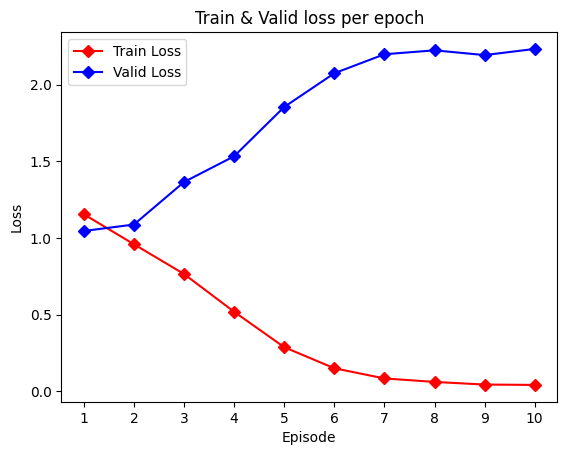

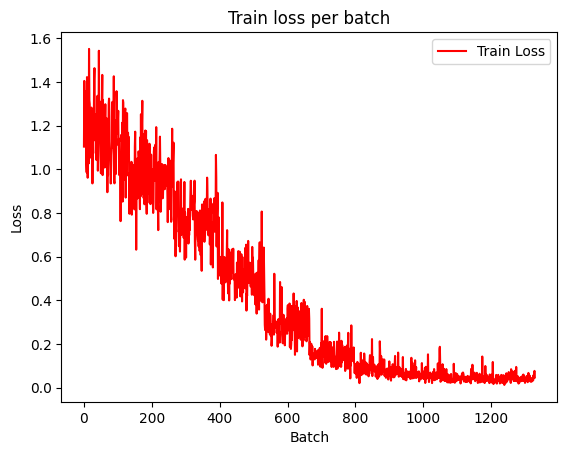

/tmp/ipython-input-2589729335.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["train_accuracies_per_epoch"], '-gD', color = "red", label='Train Accuracy')
/tmp/ipython-input-2589729335.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_accuracies_per_epoch"], '-gD', color = "blue", label='Valid Accuracy')


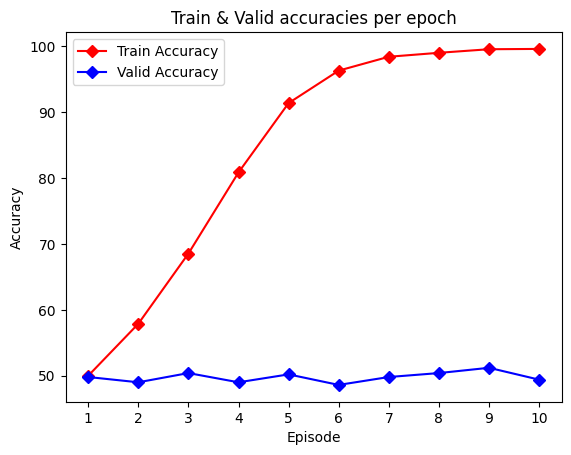

/tmp/ipython-input-2589729335.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_precision_per_epoch"], '-gD', color = "red", label='Precision')
/tmp/ipython-input-2589729335.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_recall_per_epoch"], '-gD', color = "blue", label='Recall')
/tmp/ipython-input-2589729335.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(list_of_epochs, metrics["valid_f1_per_epoch"], '-gD', color = "green", label='f1')


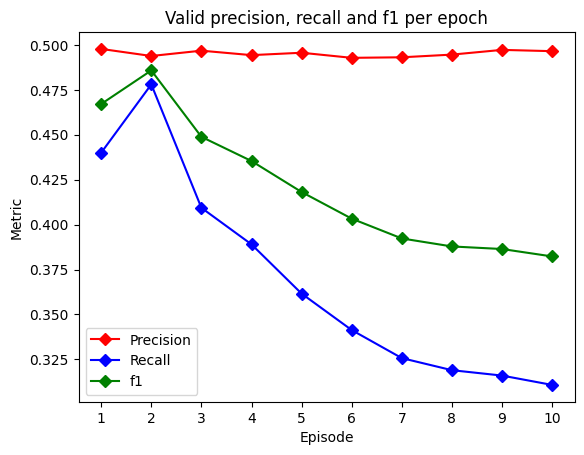

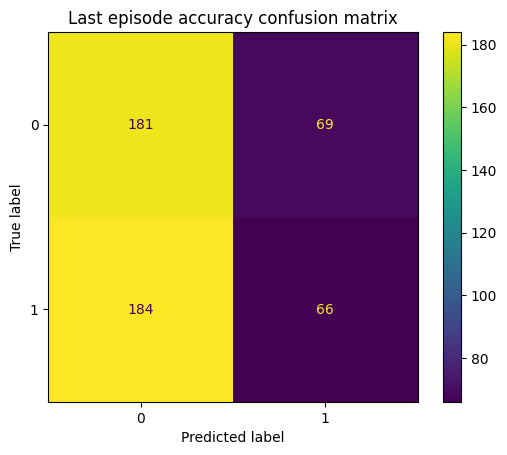

In [ ]:
plot_graphs(batch_norm_2d_metrics)